In [1]:
from collections import Counter # se usará? la saqué del notebook "pandas introduccion"
import requests # se usará? la saqué del notebook "pandas introduccion"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

In [2]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("fiufip_dataset.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
        

In [3]:
import pandas as pd
df = pd.read_csv("fiufip_dataset.csv")

## Veamos de que consta el dataset provisto

In [4]:
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado


In [5]:
df.shape

(32561, 13)

## Comienzo de posibles preguntas

**¿Existe alguna relación entre las horas de trabajo registradas y el rol familiar registado?**

Realicemos un breve analisis de ambas features

In [6]:
df[['horas_trabajo_registradas','rol_familiar_registrado']].isnull().sum()

horas_trabajo_registradas    0
rol_familiar_registrado      0
dtype: int64

Dejo esta idea por aca

Obtengamos las horas promedio segun cada rol

In [7]:
pf = df.groupby('rol_familiar_registrado').agg(list)



In [8]:
pf['promedio'] = pf['horas_trabajo_registradas'].apply(np.mean)
pf = pf['promedio']

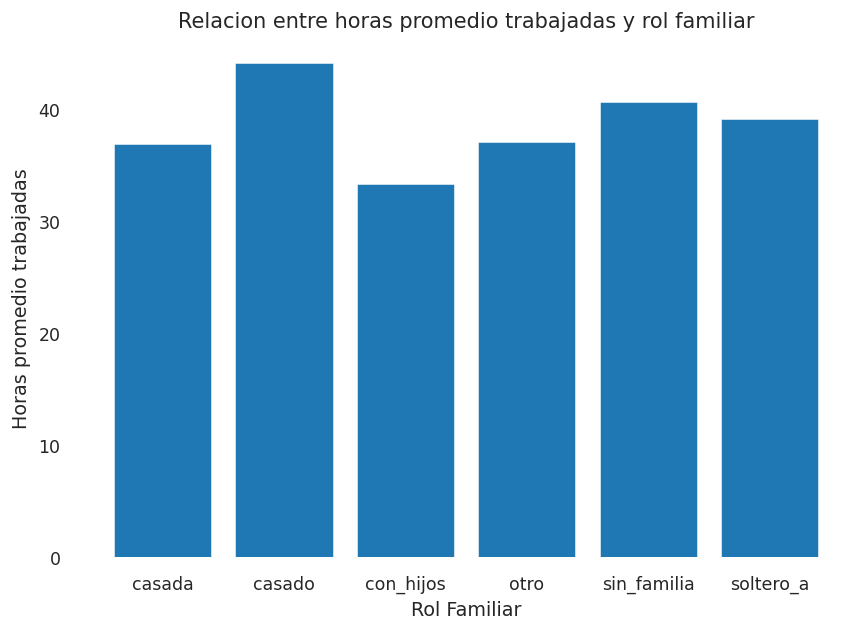

In [9]:
plt.figure(dpi=125)
plt.bar(pf.index,pf.values)
plt.xlabel("Rol Familiar")
plt.ylabel("Horas promedio trabajadas")
plt.title("Relacion entre horas promedio trabajadas y rol familiar")
plt.show()

Se observa una breve disminucion en las horas promedio trabajadas al tener hijos. Dudo mucho que esto sea util para algo

In [10]:
gente_por_trabajo = df['trabajo'].value_counts()
gente_por_trabajo

profesional_especializado    4140
reparador                    4099
directivo_gerente            4066
entretenimiento              3770
ventas                       3650
otros                        3295
inspector                    2002
transporte                   1597
limpiador                    1370
sector_primario               994
soporte_tecnico               928
seguridad                     649
servicio_domestico            149
ejercito                        9
Name: trabajo, dtype: int64

Aca me parece que los nulos, seria por que la persona no trabaja

In [11]:

gente_por_categoria_de_trabajo = df['categoria_de_trabajo'].value_counts()
gente_por_categoria_de_trabajo.sum()

30725

In [12]:
df.isnull().sum()

anios_estudiados                                 0
barrio                                         583
categoria_de_trabajo                          1836
edad                                             0
educacion_alcanzada                              0
estado_marital                                   0
ganancia_perdida_declarada_bolsa_argentina       0
genero                                           0
horas_trabajo_registradas                        0
religion                                         0
rol_familiar_registrado                          0
tiene_alto_valor_adquisitivo                     0
trabajo                                       1843
dtype: int64

Se puede ver que hay varios faltantes, lo raro seria que segun el dataset tributan, pero sin trabajo¡? ademas si les da verguenza pueden poner otros como opcion, por eso es raro

In [13]:
cantidad_por_educacion_alcanzada = df['educacion_alcanzada'].value_counts()
cantidad_por_educacion_alcanzada

4_anio                10501
5_anio                 7291
universidad_3_anio     5355
universidad_4_anio     1723
universidad_1_anio     1382
2_anio                 1175
universidad_2_anio     1067
1_anio                  933
7-8_grado               646
universiada_5_anio      576
9_grado                 514
3_anio                  433
universiada_6_anio      413
5-6_grado               333
1-4_grado               168
preescolar               51
Name: educacion_alcanzada, dtype: int64

Aca potencialmente podriamos reducir la cardinalidad agrupando en si termino el secuandario, si termino la facultad, etc

In [14]:
 df['estado_marital'].value_counts()

matrimonio_civil      14976
sin_matrimonio        10683
divorciado             4443
separado               1025
viudo_a                 993
pareja_no_presente      418
matrimonio_militar       23
Name: estado_marital, dtype: int64

Esta feature no se si tiene algo en cuanto a su cardinalidad interesante para decir, solo eso que habias marcado la inconsistencia de casado/casada

# ¿Cuanta gente tiene declaradas ganancias o perdidas en la bolsa argentina?

In [15]:
 (df['ganancia_perdida_declarada_bolsa_argentina'] != 0).value_counts()

False    28330
True      4231
Name: ganancia_perdida_declarada_bolsa_argentina, dtype: int64

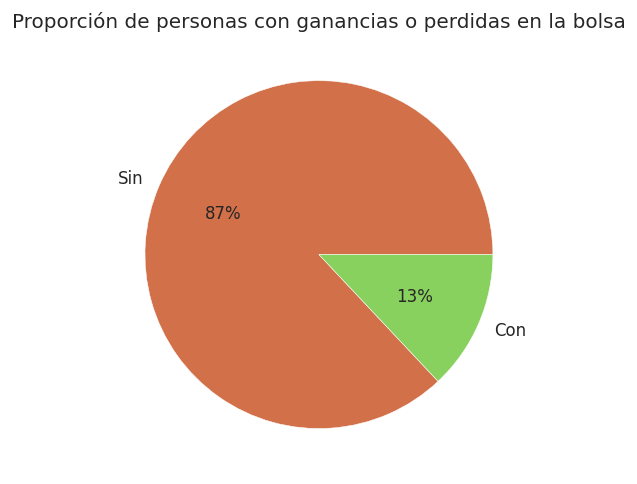

In [16]:
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.title('Proporción de personas con ganancias o perdidas en la bolsa')
plt.pie((df['ganancia_perdida_declarada_bolsa_argentina'] != 0).value_counts(), labels= ['Sin', 'Con'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.ylabel('')
plt.show()

Entoces el 87% declara no tener ganancias o perdidas en la bolsa. Dado que seria raro que el balance de justo 0, podriamos concluir que solo el 13% de los contribuyentes opera en la bolsa

## ¿Existe alguna relación entre el rol familiar del contribuyente y si opera en la bolsa de argentina?

Veamos primero la distribucion de los roles familiares entre los contribuyentes

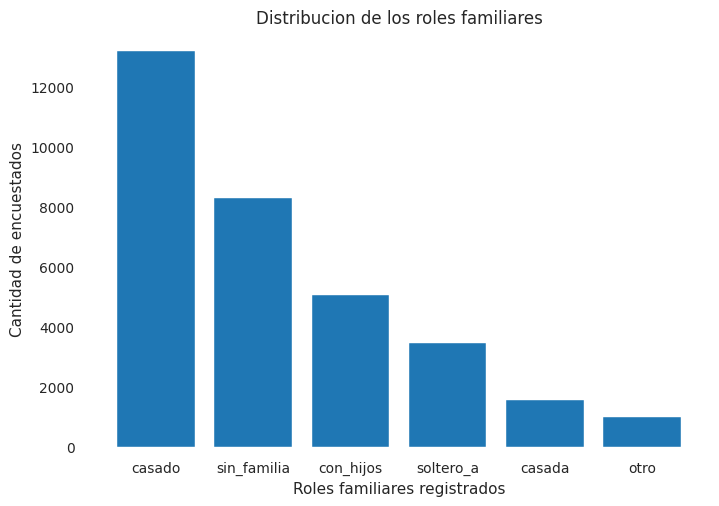

In [17]:
plt.figure(dpi=(100))
cantidad_de_encuestados_por_rol = (
    df['rol_familiar_registrado']
    .value_counts()
    .sort_values(ascending=False)
)
plt.bar(cantidad_de_encuestados_por_rol.index, cantidad_de_encuestados_por_rol.values)
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Roles familiares registrados")
plt.title('Distribucion de los roles familiares')
plt.show()

Llama la atencion que existe una categoria casada y casada, distinguiendo por género, mientrás que soltero_a no hace esta distinción. Veamos la relacion de estas categorias, y tener declarado en la bolsa

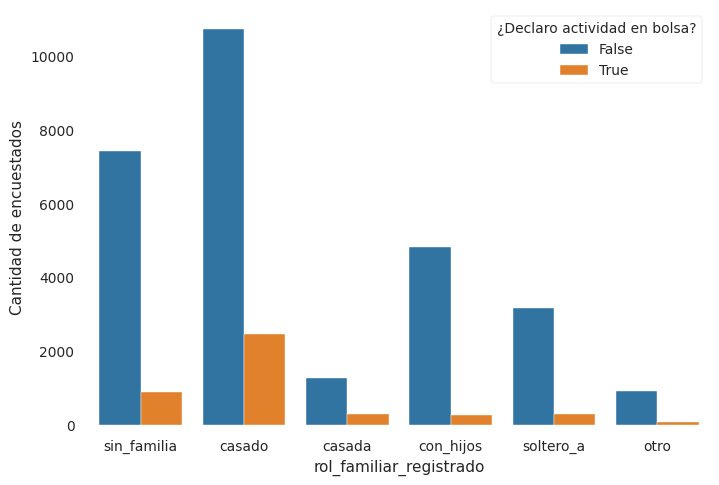

In [18]:
df['declaro_actividad_en_bolsa'] = df['ganancia_perdida_declarada_bolsa_argentina'] != 0
df['declaro_actividad_en_bolsa'].replace(False,0)
plt.figure(dpi = (100))


bar_plot = sns.countplot(data=df, x='rol_familiar_registrado', hue='declaro_actividad_en_bolsa')
legend = bar_plot.get_legend()
legend.set_title('¿Declaro actividad en bolsa?')
labels = legend.texts
labels[0] = 'No'
labels[1] = 'Si'
bar_plot.set_ylabel('Cantidad de encuestados')




plt.show()

Ya se que habria que hacerlo porcentual, pero a priori no veo ninguna relacion que pueda ser interesante.

## ¿Existe alguna relación entre declarar altos ingresos y operar en la bolsa argentina?

Veamos que sucede con quienes declaran altos ingresos

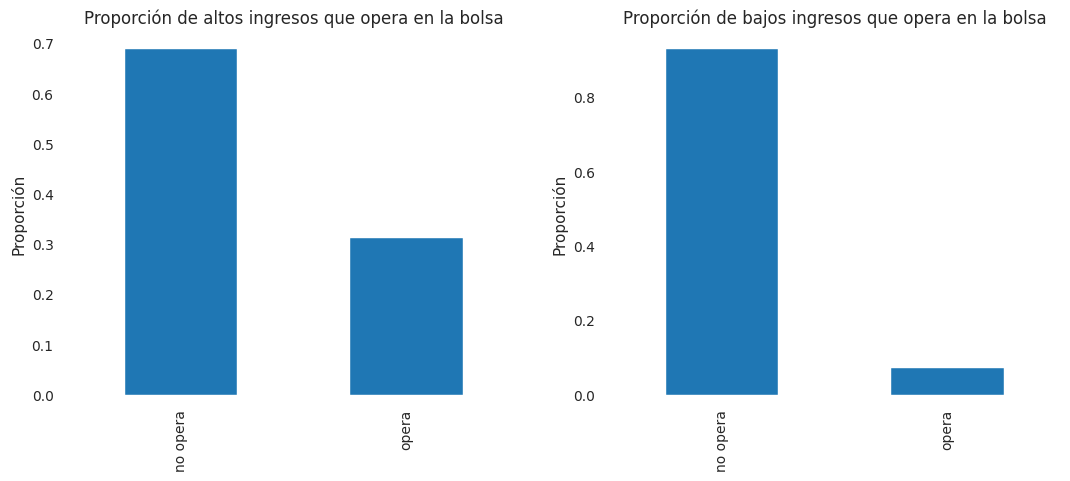

In [19]:
df['opera_en_bolsa'] = df['ganancia_perdida_declarada_bolsa_argentina'] != 0
df['gana_en_bolsa'] = df['ganancia_perdida_declarada_bolsa_argentina'] > 0
df['opera_en_bolsa'] = df['opera_en_bolsa'].replace({True : 'opera',False:'no opera'})
df['gana_en_bolsa'] = df['gana_en_bolsa'].replace({True : 'gana',False:'no_gana'})
dataset_altos_ingresos = df[df.tiene_alto_valor_adquisitivo != 0]
dataset_bajos_ingresos = df[df.tiene_alto_valor_adquisitivo == 0]



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)


dataset_altos_ingresos.opera_en_bolsa.value_counts(normalize=True).plot(kind='bar', ax=axes[0])
axes[0].set_title("Proporción de altos ingresos que opera en la bolsa")
axes[0].set_ylabel("Proporción")

bar_plot = dataset_bajos_ingresos.opera_en_bolsa.value_counts(normalize=True).plot(kind='bar', ax=axes[1])
axes[1].set_title("Proporción de bajos ingresos que opera en la bolsa")
axes[1].set_ylabel("Proporción")



plt.show()


Aca puede haber una relación interesante, porque el 30% de los que declaran altos ingresos operan en la bolsa. Veamos si declaran una ganancia positiva

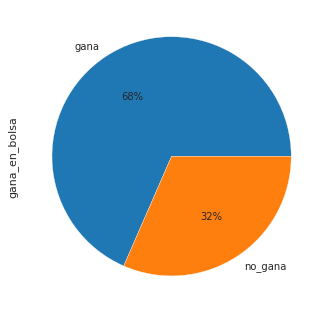

In [39]:
dataset_altos_que_operan = dataset_altos_ingresos[dataset_altos_ingresos.opera_en_bolsa == 'opera']
dataset_altos_que_operan.gana_en_bolsa.value_counts(normalize=True).plot(kind='pie',autopct='%1.0f%%')
plt.show()


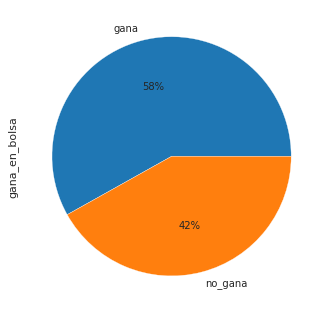

In [40]:
dataset_bajos_que_operan = dataset_bajos_ingresos[dataset_bajos_ingresos.opera_en_bolsa == 'opera']
dataset_bajos_que_operan.gana_en_bolsa.value_counts(normalize=True).plot(kind='pie',autopct='%1.0f%%')
plt.show()

Los graficos y como los construyo es horrible. Pero de aca se puede ver que el porcentaje de los que operan de altos ingresos que gana es un 10% mayor y además que en general lo que operan en bolsa ganan

# Hago intento del pipeline en base a esta info

In [29]:

#pred[df.trabajo == 'directivo_gerente'] = 1
df['alto'] = (df['ganancia_perdida_declarada_bolsa_argentina'] != 0) 
accuracy_score(df.tiene_alto_valor_adquisitivo,df.alto)


0.7797364945794049

Jeje, tirando un poco por tirar casi llego al 80% correcto, igual tampoco es mucho contando que arranque en 75%...